In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded=files.upload()




In [ ]:
df=pd.read_csv('hurdat2-1851-2019-052520.csv', names=['id', 'time', 'record_identifier','status','latitude','longitude','max_sust_wind', 'min_press'])
df.head()

,id,time,record_identifier,status,latitude,longitude,max_sust_wind,min_press
0,AL011851,UNNAMED,14,NaN,NaN,NaN,NaN,NaN
1,18510625,0000,,HU,28.0N,94.8W,80.0,-999.0
2,18510625,0600,,HU,28.0N,95.4W,80.0,-999.0
3,18510625,1200,,HU,28.0N,96.0W,80.0,-999.0
4,18510625,1800,,HU,28.1N,96.5W,80.0,-999.0


In [ ]:
#Add Unique identifier (id-name) column
df['id-name']=df['id']*df['max_sust_wind'].isnull()+df['max_sust_wind'].isnull()*df['time']

df.loc[(df['id-name']==''),'id-name']=np.NaN
df.loc[(df['min_press']==-999, 'min_press')]=np.NaN #Set unknown minimum pressure as NaN
u_hur_=df['id-name'].value_counts().sum()
print(u_hur_)
df.tail(50)

1893


,id,time,record_identifier,status,latitude,longitude,max_sust_wind,min_press,id-name
53683,20191029,0000,,EX,42.2N,40.1W,55.0,971.0,NaN
53684,20191029,0600,,EX,42.3N,38.5W,55.0,973.0,NaN
53685,20191029,1200,,EX,43.0N,38.9W,55.0,975.0,NaN
53686,20191029,1800,,EX,43.4N,40.6W,50.0,977.0,NaN
53687,20191030,0000,,EX,41.8N,42.7W,50.0,979.0,NaN
53688,20191030,0600,,EX,39.9N,43.7W,50.0,980.0,NaN
53689,20191030,1200,,SS,38.3N,42.8W,45.0,982.0,NaN
53690,20191030,1800,,SS,38.1N,41.5W,45.0,984.0,NaN
53691,20191031,0000,,SS,38.4N,40.0W,45.0,986.0,NaN
53692,20191031,0600,,SS,39.3N,37.7W,40.0,988.0,NaN


In [ ]:
df['drop_']=df['id-name'] # Add column to tag rows to be dropped later
df['id-name'].fillna(method='ffill',inplace=True) #Fill id-name column
pd.set_option('display.max_rows', 200)
# print(df.loc[len(df)-100:len(df),'id-name'])
df.tail(100)

,id,time,record_identifier,status,latitude,longitude,max_sust_wind,min_press,id-name,drop_
53633,20191019,1200,,EX,29.3N,86.4W,40.0,996.0,AL162019 NESTOR,NaN
53634,20191019,1800,,EX,30.2N,85.4W,40.0,999.0,AL162019 NESTOR,NaN
53635,20191020,0000,,EX,31.2N,84.2W,35.0,1000.0,AL162019 NESTOR,NaN
53636,20191020,0600,,EX,33.1N,81.7W,40.0,1002.0,AL162019 NESTOR,NaN
53637,20191020,1200,,EX,35.1N,79.1W,40.0,1002.0,AL162019 NESTOR,NaN
53638,20191020,1800,,EX,37.0N,76.7W,40.0,1002.0,AL162019 NESTOR,NaN
53639,20191021,0000,,EX,37.5N,74.5W,40.0,1001.0,AL162019 NESTOR,NaN
53640,AL172019,OLGA,10,NaN,NaN,NaN,NaN,NaN,AL172019 OLGA,AL172019 OLGA
53641,20191025,1200,,TS,24.7N,94.8W,35.0,1004.0,AL172019 OLGA,NaN
53642,20191025,1800,,TS,25.9N,93.6W,40.0,998.0,AL172019 OLGA,NaN


In [ ]:
# Set unique identifier as index
# df.set_index(df['id-name'], inplace=True)

In [ ]:
#Calculate Number of Hurricanes and check
# total_hur=df['id-name'].nunique()
# total_hur
# assert total_hur==u_hur_
# total_hur
# list_hur=df['id-name'].unique().tolist()
# list_hur

In [ ]:
#Create dataframe with max wind speed, mean wind speed, minimum pressure, mean pressure, and year of each hurricane
max_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].max()
max_speed=pd.DataFrame(max_speed)
max_speed.reset_index(inplace=True)
max_speed.rename(columns={"max_sust_wind": "max_wind"}, inplace=True)
print('Max Speed reached: ', max_speed)
max_speed.head()

mean_speed=df.groupby(['id-name'], sort=None)['max_sust_wind'].mean()
mean_speed=pd.DataFrame(mean_speed)
mean_speed.reset_index(inplace=True)
mean_speed.rename(columns={"max_sust_wind": "mean_wind"}, inplace=True)
print('Mean of Maximum Speed: ', mean_speed)

min_pressure=df.groupby(['id-name'], sort=None)['min_press'].min()
min_pressure=pd.DataFrame(min_pressure)
min_pressure.reset_index(inplace=True)
print('Minimum Pressure reached: ', min_pressure)

mean_pressure=df.groupby(['id-name'], sort=None)['min_press'].mean()
mean_pressure=pd.DataFrame(mean_pressure)
mean_pressure.reset_index(inplace=True)
mean_pressure.rename(columns={"min_press": "mean_of_min_press"}, inplace=True)

print('Mean of Minimum Pressure: ', mean_pressure)


Max Speed reached:                            id-name  max_wind
0     AL011851            UNNAMED      80.0
1     AL021851            UNNAMED      80.0
2     AL031851            UNNAMED      50.0
3     AL041851            UNNAMED     100.0
4     AL051851            UNNAMED      50.0
...                           ...       ...
1888  AL162019             NESTOR      50.0
1889  AL172019               OLGA      45.0
1890  AL182019              PABLO      70.0
1891  AL192019            REBEKAH      70.0
1892  AL202019          SEBASTIEN      60.0

[1893 rows x 2 columns]
Mean of Maximum Speed:                            id-name  mean_wind
0     AL011851            UNNAMED  60.714286
1     AL021851            UNNAMED  80.000000
2     AL031851            UNNAMED  50.000000
3     AL041851            UNNAMED  65.102041
4     AL051851            UNNAMED  50.000000
...                           ...        ...
1888  AL162019             NESTOR  42.000000
1889  AL172019               OLGA  37.00000

In [ ]:
#drop rows
df_hur=df.dropna(subset=['drop_'])
df_hur.drop(columns=['status','latitude','longitude', 'drop_', 'record_identifier','max_sust_wind',	'min_press'], inplace=True)
df_hur.head(100)
df_hur.rename(columns={"time": "Name"}, inplace=True)
df_hur.head(20)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,Name,id-name
0,AL011851,UNNAMED,AL011851 UNNAMED
15,AL021851,UNNAMED,AL021851 UNNAMED
17,AL031851,UNNAMED,AL031851 UNNAMED
19,AL041851,UNNAMED,AL041851 UNNAMED
69,AL051851,UNNAMED,AL051851 UNNAMED
86,AL061851,UNNAMED,AL061851 UNNAMED
104,AL011852,UNNAMED,AL011852 UNNAMED
150,AL021852,UNNAMED,AL021852 UNNAMED
159,AL031852,UNNAMED,AL031852 UNNAMED
180,AL041852,UNNAMED,AL041852 UNNAMED


In [ ]:
df_hur['year']=df_hur['id'].str[-4:]
df_hur.reset_index() 
df_hur.head() #Add year column

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,Name,id-name,year
0,AL011851,UNNAMED,AL011851 UNNAMED,1851
15,AL021851,UNNAMED,AL021851 UNNAMED,1851
17,AL031851,UNNAMED,AL031851 UNNAMED,1851
19,AL041851,UNNAMED,AL041851 UNNAMED,1851
69,AL051851,UNNAMED,AL051851 UNNAMED,1851


In [ ]:
df_hur=pd.merge(df_hur, max_speed, on=['id-name'])
df_hur.head()

,id,Name,id-name,year,max_wind
0,AL011851,UNNAMED,AL011851 UNNAMED,1851,80.0
1,AL021851,UNNAMED,AL021851 UNNAMED,1851,80.0
2,AL031851,UNNAMED,AL031851 UNNAMED,1851,50.0
3,AL041851,UNNAMED,AL041851 UNNAMED,1851,100.0
4,AL051851,UNNAMED,AL051851 UNNAMED,1851,50.0


In [ ]:
df_hur=pd.merge(df_hur, mean_speed, on=['id-name'])
df_hur.head()

,id,Name,id-name,year,max_wind,mean_wind
0,AL011851,UNNAMED,AL011851 UNNAMED,1851,80.0,60.714286
1,AL021851,UNNAMED,AL021851 UNNAMED,1851,80.0,80.000000
2,AL031851,UNNAMED,AL031851 UNNAMED,1851,50.0,50.000000
3,AL041851,UNNAMED,AL041851 UNNAMED,1851,100.0,65.102041
4,AL051851,UNNAMED,AL051851 UNNAMED,1851,50.0,50.000000


In [ ]:
df_hur=pd.merge(df_hur, min_pressure, on=['id-name'])
df_hur.head(10)

,id,Name,id-name,year,max_wind,mean_wind,min_press
0,AL011851,UNNAMED,AL011851 UNNAMED,1851,80.0,60.714286,NaN
1,AL021851,UNNAMED,AL021851 UNNAMED,1851,80.0,80.000000,NaN
2,AL031851,UNNAMED,AL031851 UNNAMED,1851,50.0,50.000000,NaN
3,AL041851,UNNAMED,AL041851 UNNAMED,1851,100.0,65.102041,NaN
4,AL051851,UNNAMED,AL051851 UNNAMED,1851,50.0,50.000000,NaN
5,AL061851,UNNAMED,AL061851 UNNAMED,1851,60.0,52.941176,NaN
6,AL011852,UNNAMED,AL011852 UNNAMED,1852,100.0,73.333333,961.0
7,AL021852,UNNAMED,AL021852 UNNAMED,1852,70.0,57.500000,NaN
8,AL031852,UNNAMED,AL031852 UNNAMED,1852,70.0,67.000000,NaN
9,AL041852,UNNAMED,AL041852 UNNAMED,1852,80.0,72.777778,NaN


In [ ]:
df_hur=pd.merge(df_hur, mean_pressure, on=['id-name'])
df_hur.head(25)

,id,Name,id-name,year,max_wind,mean_wind,min_press,mean_of_min_press
0,AL011851,UNNAMED,AL011851 UNNAMED,1851,80.0,60.714286,NaN,NaN
1,AL021851,UNNAMED,AL021851 UNNAMED,1851,80.0,80.000000,NaN,NaN
2,AL031851,UNNAMED,AL031851 UNNAMED,1851,50.0,50.000000,NaN,NaN
3,AL041851,UNNAMED,AL041851 UNNAMED,1851,100.0,65.102041,NaN,NaN
4,AL051851,UNNAMED,AL051851 UNNAMED,1851,50.0,50.000000,NaN,NaN
5,AL061851,UNNAMED,AL061851 UNNAMED,1851,60.0,52.941176,NaN,NaN
6,AL011852,UNNAMED,AL011852 UNNAMED,1852,100.0,73.333333,961.0,961.0
7,AL021852,UNNAMED,AL021852 UNNAMED,1852,70.0,57.500000,NaN,NaN
8,AL031852,UNNAMED,AL031852 UNNAMED,1852,70.0,67.000000,NaN,NaN
9,AL041852,UNNAMED,AL041852 UNNAMED,1852,80.0,72.777778,NaN,NaN


In [ ]:
max_wind_year=df_hur.groupby(['year'], sort=None)['max_wind'].max()

min_press_year=df_hur.groupby(['year'], sort=None)['min_press'].min()

num_hur_year=df_hur['year'].value_counts()

# unique_years=df_hur['year'].unique()
# unique_years
df_year=pd.DataFrame({'year': df_hur['year'].unique(), 'max_wind': max_wind_year, 'min_press': min_press_year, 'No_of_Hurricanes': num_hur_year})

df_year

,year,max_wind,min_press,No_of_Hurricanes
1851,1851,100.0,NaN,6
1852,1852,100.0,961.0,5
1853,1853,130.0,924.0,8
1854,1854,110.0,938.0,5
1855,1855,110.0,997.0,5
1856,1856,130.0,934.0,6
1857,1857,90.0,961.0,4
1858,1858,90.0,979.0,6
1859,1859,110.0,938.0,8
1860,1860,110.0,NaN,7


In [ ]:
df_year['year'] = pd.DatetimeIndex(pd.to_datetime(df_year['year'])).year
print(df_year['year'][3].dtype)
df_year.head()
# df_year.dtypes



int64


,year,max_wind,min_press,No_of_Hurricanes
1851,1851,100.0,NaN,6
1852,1852,100.0,961.0,5
1853,1853,130.0,924.0,8
1854,1854,110.0,938.0,5
1855,1855,110.0,997.0,5


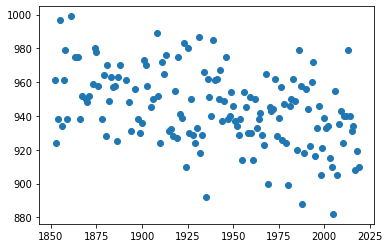

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df_year['year'], df_year['min_press'])

In [ ]:
from statsmodels.formula.api import ols
model=ols('min_press ~ max_wind', data=df_hur).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              min_press   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     9320.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:08:59   Log-Likelihood:                -3891.0
No. Observations:                1113   AIC:                             7786.
Df Residuals:                    1111   BIC:                             7796.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1036.7694      0.647   1602.507      0.0

In [ ]:
from statsmodels.formula.api import ols
model=ols('max_wind ~ year', data=df_year).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               max_wind   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     45.28
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           2.61e-10
Time:                        23:11:53   Log-Likelihood:                -735.67
No. Observations:                 169   AIC:                             1475.
Df Residuals:                     167   BIC:                             1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -273.2520     57.737     -4.733      0.0

In [ ]:
from statsmodels.formula.api import ols
model=ols('No_of_Hurricanes ~ year', data=df_year).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       No_of_Hurricanes   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     121.1
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           1.60e-21
Time:                        23:12:31   Log-Likelihood:                -484.33
No. Observations:                 169   AIC:                             972.7
Df Residuals:                     167   BIC:                             978.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -132.3194     13.048    -10.141      0.0

In [ ]:
from statsmodels.formula.api import ols
model=ols('max_wind ~ year', data=df_year).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               max_wind   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     45.28
Date:                Thu, 28 Jan 2021   Prob (F-statistic):           2.61e-10
Time:                        23:13:34   Log-Likelihood:                -735.67
No. Observations:                 169   AIC:                             1475.
Df Residuals:                     167   BIC:                             1482.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -273.2520     57.737     -4.733      0.0